In [ ]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

pd.options.mode.chained_assignment = None
seed = 0
np.random.seed(seed)
sns.set(style = 'whitegrid')

import datetime as dt
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import string
import re
from nltk.probability import FreqDist

from wordcloud import WordCloud

from keras.preprocessing.text import Tokenizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## import data


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/privy_or_privyid_twitter.xlsx')

In [ ]:
df.head()

,day_name,tanggal,Month,Year,Date,Time,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url
0,Mon,14,Nov,2022,2022-11-14,07:25:47,"Startup tanda tangan digital, Privy, mendapatk...",0,0,0,3,in,135795460,1592056183245766912,detikfinance,https://twitter.com/detikfinance/status/159205...
1,Mon,14,Nov,2022,2022-11-14,13:03:02,Startup penyedia layanan tanda tangan digital ...,0,0,0,1,in,23046757,1592141054169711104,dailysocial,https://twitter.com/dailysocial/status/1592141...
2,Mon,14,Nov,2022,2022-11-14,09:40:05,Startup Identitas Digital Privy Raih Pendanaan...,0,0,0,0,in,118646322,1592089978762592000,Bisniscom,https://twitter.com/Bisniscom/status/159208997...
3,Mon,14,Nov,2022,2022-11-14,06:50:26,Privy Kantongi Pendanaan Seri C Sebesar 744 Mi...,0,0,0,0,in,23046757,1592047286023962880,dailysocial,https://twitter.com/dailysocial/status/1592047...
4,Mon,14,Nov,2022,2022-11-14,07:05:37,Privy Kantongi Pendanaan Seri C Sebesar 744 Mi...,0,0,0,0,in,92270363,1592051107886661888,Arifai777,https://twitter.com/Arifai777/status/159205110...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864 entries, 0 to 863
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   day_name             864 non-null    object        
 1   tanggal              864 non-null    int64         
 2   Month                864 non-null    object        
 3   Year                 864 non-null    int64         
 4   Date                 864 non-null    datetime64[ns]
 5   Time                 864 non-null    object        
 6   full_text            864 non-null    object        
 7   quote_count          864 non-null    int64         
 8   reply_count          864 non-null    int64         
 9   retweet_count        864 non-null    int64         
 10  favorite_count       864 non-null    int64         
 11  lang                 864 non-null    object        
 12  user_id_str          864 non-null    int64         
 13  conversation_id_str  864 non-null  

## EDA

In [ ]:
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objects as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import plotly.express as px

In [ ]:
total_tweet = df.groupby('Date')['day_name'].count()

fig = go.Figure([go.Scatter(x=total_tweet.index, y=total_tweet.values)])
fig.show(renderer="colab")

In [ ]:
dfg = df.groupby(['username']).size().to_frame().sort_values([0], ascending = False).head(10).reset_index()
fig = px.histogram(dfg, x='username', y = 0)
fig.show(renderer="colab")

## cleansing

In [ ]:
df_2 = df[['full_text']]

In [ ]:
tweet = list(df_2['full_text'])

In [ ]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in indonesia.
stopwordlist = ["nya","ya","yg","ada","adalah","adanya","adapun","agak","agaknya","agar","akan","akankah","akhir","akhiri","akhirnya","aku","akulah","amat","amatlah","anda","andalah","antar","antara","antaranya","apa","apaan","apabila","apakah","apalagi","apatah","artinya","asal","asalkan","atas","atau","ataukah","ataupun","awal","awalnya","bagai","bagaikan","bagaimana","bagaimanakah","bagaimanapun","bagi","bagian","bahkan","bahwa","bahwasanya","baik","bakal","bakalan","balik","banyak",
                "bapak","baru","bawah","beberapa","begini","beginian","beginikah","beginilah","begitu","begitukah","begitulah","begitupun","bekerja","belakang","belakangan","belum","belumlah","benar","benarkah","benarlah","berada","berakhir","berakhirlah","berakhirnya","berapa","berapakah","berapalah","berapapun","berarti","berawal","berbagai","berdatangan","beri","berikan","berikut","berikutnya","berjumlah","berkali-kali","berkata","berkehendak","berkeinginan","berkenaan","berlainan","berlalu","berlangsung","berlebihan","bermacam","bermacam-macam","bermaksud","bermula","bersama",
                "bersama-sama","bersiap","bersiap-siap","bertanya","bertanya-tanya","berturut","berturut-turut","bertutur","berujar","berupa","besar","betul","betulkah","biasa","biasanya","bila","bilakah","bisa","bisakah","boleh","bolehkah","bolehlah","buat","bukan","bukankah","bukanlah","bukannya","bulan","bung","cara","caranya","cukup","cukupkah","cukuplah","cuma","dahulu","dalam","dan","dapat","dari","daripada","datang","dekat","demi","demikian","demikianlah","dengan","depan","di","dia","diakhiri",
                "diakhirinya","dialah","diantara","diantaranya","diberi","diberikan","diberikannya","dibuat","dibuatnya","didapat","didatangkan","digunakan","diibaratkan","diibaratkannya","diingat","diingatkan","diinginkan","dijawab","dijelaskan","dijelaskannya","dikarenakan","dikatakan","dikatakannya","dikerjakan","diketahui","diketahuinya","dikira","dilakukan","dilalui","dilihat","dimaksud","dimaksudkan","dimaksudkannya","dimaksudnya","diminta","dimintai","dimisalkan","dimulai","dimulailah","dimulainya","dimungkinkan","dini","dipastikan","diperbuat","diperbuatnya","dipergunakan","diperkirakan","diperlihatkan","diperlukan","diperlukannya","dipersoalkan","dipertanyakan",
                "dipunyai","diri","dirinya","disampaikan","disebut","disebutkan","disebutkannya","disini","disinilah","ditambahkan","ditandaskan","ditanya","ditanyai","ditanyakan","ditegaskan","ditujukan","ditunjuk","ditunjuki","ditunjukkan","ditunjukkannya","ditunjuknya","dituturkan","dituturkannya","diucapkan","diucapkannya","diungkapkan","dong","dua","dulu","empat","enggak","enggaknya","entah","entahlah","guna","gunakan","hal","hampir","hanya","hanyalah","hari","harus","haruslah","harusnya","hendak","hendaklah","hendaknya","hingga","ia",
                "ialah","ibarat","ibaratkan","ibaratnya","ibu","ikut","ingat","ingat-ingat","ingin","inginkah","inginkan","ini","inikah","inilah","itu","itukah","itulah","jadi","jadilah","jadinya","jangan","jangankan","janganlah","jauh","jawab","jawaban","jawabnya","jelas","jelaskan","jelaslah","jelasnya","jika","jikalau","juga","jumlah","jumlahnya","justru","kala","kalau","kalaulah","kalaupun","kalian","kami","kamilah","kamu","kamulah","kan","kapan","kapankah",
                "kapanpun","karena","karenanya","kasus","kata","katakan","katakanlah","katanya","ke","keadaan","kebetulan","kecil","kedua","keduanya","keinginan","kelamaan","kelihatan","kelihatannya","kelima","keluar","kembali","kemudian","kemungkinan","kemungkinannya","kenapa","kepada","kepadanya","kesampaian","keseluruhan","keseluruhannya","keterlaluan","ketika","khususnya","kini","kinilah","kira","kira-kira","kiranya","kita","kitalah","kok","kurang","lagi","lagian","lah","lain","lainnya","lalu",
                "lama","lamanya","lanjut","lanjutnya","lebih","lewat","lima","luar","macam","maka","makanya","makin","malah","malahan","mampu","mampukah","mana","manakala","manalagi","masa","masalah","masalahnya","masih","masihkah","masing","masing-masing","mau","maupun","melainkan","melakukan","melalui","melihat","melihatnya","memang","memastikan","memberi","memberikan","membuat","memerlukan","memihak","meminta","memintakan","memisalkan",
                "memperbuat","mempergunakan","memperkirakan","memperlihatkan","mempersiapkan","mempersoalkan","mempertanyakan","mempunyai","memulai","memungkinkan","menaiki","menambahkan","menandaskan","menanti","menanti-nanti","menantikan","menanya","menanyai","menanyakan","mendapat","mendapatkan","mendatang","mendatangi","mendatangkan","menegaskan","mengakhiri","mengapa","mengatakan","mengatakannya","mengenai","mengerjakan","mengetahui","menggunakan","menghendaki","mengibaratkan","mengibaratkannya","mengingat","mengingatkan","menginginkan","mengira","mengucapkan","mengucapkannya","mengungkapkan","menjadi","menjawab","menjelaskan",
                "menuju","menunjuk","menunjuki","menunjukkan","menunjuknya","menurut","menuturkan","menyampaikan","menyangkut","menyatakan","menyebutkan","menyeluruh","menyiapkan","merasa","mereka","merekalah","merupakan","meski","meskipun","meyakini","meyakinkan","minta","mirip","misal","misalkan","misalnya","mula","mulai","mulailah","mulanya","mungkin","mungkinkah","nah","naik","namun","nanti","nantinya","nyaris","nyatanya","oleh","olehnya","pada","padahal","padanya",
                "pak","paling","panjang","pantas","para","pasti","pastilah","penting","pentingnya","per","percuma","perlu","perlukah","perlunya","pernah","persoalan","pertama","pertama-tama","pertanyaan","pertanyakan","pihak","pihaknya","pukul","pula","pun","punya","rasa","rasanya","rata","rupanya","saat","saatnya","saja","sajalah","saling","sama","sama-sama","sambil","sampai","sampai-sampai","sampaikan","sana","sangat","sangatlah","satu","saya",
                "sayalah","se","sebab","sebabnya","sebagai","sebagaimana","sebagainya","sebagian","sebaik","sebaik-baiknya","sebaiknya","sebaliknya","sebanyak","sebegini","sebegitu","sebelum","sebelumnya","sebenarnya","seberapa","sebesar","sebetulnya","sebisanya","sebuah","sebut","sebutlah","sebutnya","secara","secukupnya","sedang","sedangkan","sedemikian","sedikit","sedikitnya","seenaknya","segala","segalanya","segera","seharusnya","sehingga","seingat","sejak","sejauh","sejenak","sejumlah","sekadar","sekadarnya","sekali","sekali-kali","sekalian","sekaligus",
                "sekalipun","sekarang","sekarang","sekecil","seketika","sekiranya","sekitar","sekitarnya","sekurang-kurangnya","sekurangnya","sela","selain","selaku","selalu","selama","selama-lamanya","selamanya","selanjutnya","seluruh","seluruhnya","semacam","semakin","semampu","semampunya","semasa","semasih","semata","semata-mata","semaunya","sementara","semisal","semisalnya","sempat","semua","semuanya","semula","sendiri","sendirian","sendirinya","seolah",
                "seolah-olah","seorang","sepanjang","sepantasnya","sepantasnyalah","seperlunya","seperti","sepertinya","sepihak","sering","seringnya","serta","serupa","sesaat","sesama","sesampai","sesegera","sesekali","seseorang","sesuatu","sesuatunya","sesudah","sesudahnya","setelah","setempat","setengah","seterusnya","setiap","setiba","setibanya","setidak-tidaknya","setidaknya","setinggi","seusai","sewaktu","siap","siapa","siapakah","siapapun","sini","sinilah",
                "soal","soalnya","suatu","sudah","sudahkah","sudahlah","supaya","tadi","tadinya","tahu","tahun","tak","tambah","tambahnya","tampak","tampaknya","tandas","tandasnya","tanpa","tanya","tanyakan","tanyanya","tapi","tegas","tegasnya","telah","tempat","tengah","tentang","tentu","tentulah","tentunya","tepat","terakhir","terasa","terbanyak","terdahulu","terdapat","terdiri","terhadap","terhadapnya","teringat","teringat-ingat","terjadi","terjadilah","terjadinya","terkira","terlalu","terlebih","terlihat","termasuk","ternyata","tersampaikan","tersebut","tersebutlah","tertentu","tertuju","terus","terutama","tetap","tetapi","tiap","tiba",
                "tiba-tiba","tidak","tidakkah","tidaklah","tiga","tinggi","toh","tunjuk","turut","tutur","tuturnya","ucap","ucapnya","ujar","ujarnya","umum","umumnya","ungkap","ungkapnya","untuk","usah","usai","waduh","wah","wahai","waktu","waktunya","walau","walaupun","wong","yaitu","yakin","yakni","yang"]

In [ ]:
def preprocess(textdata):
    processedText = []

    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()

    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for tweet in textdata:
        tweet = tweet.lower()

        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,'',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
        # # Replace @USERNAME to 'USER'.
        # tweet = re.sub(userPattern,' USER', tweet)
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            if word not in stopwordlist:
              if len(word)>1:
                  # Lemmatizing the word.
                  word = wordLemm.lemmatize(word)
                  tweetwords += (word+' ')

        processedText.append(tweetwords)

    return processedText

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import time
t = time.time()
processedtext = preprocess(tweet)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 2 seconds


In [ ]:
result = pd.DataFrame(processedtext)

In [ ]:
result.head()

,0
0,startup tanda tangan digital privy pendanaan r...
1,startup penyedia layanan tanda tangan digital ...
2,startup identitas digital privy raih pendanaan...
3,privy kantongi pendanaan seri 744 miliar rupia...
4,privy kantongi pendanaan seri 744 miliar rupia...


In [ ]:
df['processedtext'] = processedtext

In [ ]:
df.head()

,day_name,tanggal,Month,Year,Date,Time,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url,processedtext
0,Mon,14,Nov,2022,2022-11-14,07:25:47,"Startup tanda tangan digital, Privy, mendapatk...",0,0,0,3,in,135795460,1592056183245766912,detikfinance,https://twitter.com/detikfinance/status/159205...,startup tanda tangan digital privy pendanaan r...
1,Mon,14,Nov,2022,2022-11-14,13:03:02,Startup penyedia layanan tanda tangan digital ...,0,0,0,1,in,23046757,1592141054169711104,dailysocial,https://twitter.com/dailysocial/status/1592141...,startup penyedia layanan tanda tangan digital ...
2,Mon,14,Nov,2022,2022-11-14,09:40:05,Startup Identitas Digital Privy Raih Pendanaan...,0,0,0,0,in,118646322,1592089978762592000,Bisniscom,https://twitter.com/Bisniscom/status/159208997...,startup identitas digital privy raih pendanaan...
3,Mon,14,Nov,2022,2022-11-14,06:50:26,Privy Kantongi Pendanaan Seri C Sebesar 744 Mi...,0,0,0,0,in,23046757,1592047286023962880,dailysocial,https://twitter.com/dailysocial/status/1592047...,privy kantongi pendanaan seri 744 miliar rupia...
4,Mon,14,Nov,2022,2022-11-14,07:05:37,Privy Kantongi Pendanaan Seri C Sebesar 744 Mi...,0,0,0,0,in,92270363,1592051107886661888,Arifai777,https://twitter.com/Arifai777/status/159205110...,privy kantongi pendanaan seri 744 miliar rupia...


In [ ]:
#remove number
def remove_number(text):
    return  re.sub(r"\d+", " ", text)

result['full_text'] = result[0].apply(remove_number)

In [ ]:
#remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

result['full_text'] = result['full_text'].apply(remove_punctuation)

In [ ]:
# remove single char
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", " ", text)

result['full_text'] = result['full_text'].apply(remove_singl_char)

In [ ]:
!gdown --id 1cXaOtuw6xqWL6KDjZqvkzGYsiyyr0X1y

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1cXaOtuw6xqWL6KDjZqvkzGYsiyyr0X1y
To: /content/slang.txt
100% 32.8k/32.8k [00:00<00:00, 73.6MB/s]


In [ ]:
slangs = open('slang.txt',"r",encoding="utf-8", errors='replace')

In [ ]:
clear_slangs= []
for newlines in slangs:
  strip_re = newlines.strip("\n")
  split = re.split(r'[:]',strip_re)
  clear_slangs.append(split)

In [ ]:
slangs = [[k.strip(), v.strip()] for k,v in clear_slangs]
dict_slangs = {key:values for key,values in slangs}

In [ ]:
dict_slangs

{'&': 'dan',
 'dr': 'dari',
 'abis': 'habis',
 'ad': 'ada',
 'alhmdulillah': 'alhamdulillah',
 'alhamdulilah': 'alhamdulillah',
 'alhamdulillaah': 'alhamdulillah',
 'alhamdulillah': 'alhamdulillah',
 'adminnya': 'admin nya',
 'account': 'akun',
 'asiikk': 'asyik',
 'alpukatnya': 'alpukat nya',
 'amin': 'aamiin',
 'aplikasinnya': 'aplikasi nya',
 'aplikasinya': 'aplikasi nya',
 'awesome': 'luar biasa',
 'asyilk': 'asyik',
 'antaran': 'pengantaran',
 'apus': 'hapus',
 'ampe': 'sampai',
 'almt': 'alamat',
 'almat': 'alamat',
 'alamt': 'alamat',
 'almtnya': 'alamatnya',
 'apknya': 'aplikasinya',
 'antri': 'antre',
 'adl': 'adalah',
 'awalnnya': 'awalnya',
 'asem': 'asam',
 'alumunium': 'aluminium',
 'areaku': 'area saya',
 'alpulat': 'alpukat',
 'adlah': 'adalah',
 'applikasi': 'aplikasi',
 'apps': 'aplikasi',
 'app': 'aplikasi',
 'afordable': 'affordable',
 'agent': 'agen',
 'agus': 'hangus',
 'apk': 'aplikasi',
 'appsnya': 'aplikasinya',
 'aah': 'ah',
 'apakh': 'apakah',
 'apalgi': 'apal

In [ ]:
!pip install textblob

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from textblob import TextBlob
clean_text = []
for review in result['full_text']:
  wordlist = TextBlob(review).words
  for k,v in enumerate(wordlist):
    if v in dict_slangs.keys():
      wordlist[k] = dict_slangs[v]
  clean_text.append(' '.join(wordlist))

In [ ]:
clean_text

['startup tanda tangan digital privy pendanaan rp miliar firma investasi global kkr pendanaan',
 'startup penyedia layanan tanda tangan digital identitas digital privy mengumumkan pendanaan seri senilai juta dana',
 'startup identitas digital privy raih pendanaan rp miliar ventura',
 'privy kantongi pendanaan seri miliar rupiah dipimpin kkr',
 'privy kantongi pendanaan seri miliar rupiah dipimpin kkr',
 'kkr tanam investasi seri perusahaan digital privy',
 'firma investasi global suntik rp miliar startup privy',
 'raih pendanaan seri privy berencana ekspansi negeri',
 'privy mengumumkan pendanaan seri senilai juta miliar rupiah dana',
 'privy memperoleh pendanaan anak usaha telkom investor amerika singapura startup indonesia berencana ekspansi negeri',
 'co founder ceo privy marshall pribadi senang menyambut kkr salah investor privy',
 'simak langkah langkah lolo verifikasi liveness detection unduh privy goole playstore appstore privylegeforeveryone privylegeishere privyishere privy in

In [ ]:
df['normalization'] = clean_text

In [ ]:
result['normalization'] = clean_text

In [ ]:
df.head()

,day_name,tanggal,Month,Year,Date,Time,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url,processedtext,normalization
0,Mon,14,Nov,2022,2022-11-14,07:25:47,"Startup tanda tangan digital, Privy, mendapatk...",0,0,0,3,in,135795460,1592056183245766912,detikfinance,https://twitter.com/detikfinance/status/159205...,startup tanda tangan digital privy pendanaan r...,startup tanda tangan digital privy pendanaan r...
1,Mon,14,Nov,2022,2022-11-14,13:03:02,Startup penyedia layanan tanda tangan digital ...,0,0,0,1,in,23046757,1592141054169711104,dailysocial,https://twitter.com/dailysocial/status/1592141...,startup penyedia layanan tanda tangan digital ...,startup penyedia layanan tanda tangan digital ...
2,Mon,14,Nov,2022,2022-11-14,09:40:05,Startup Identitas Digital Privy Raih Pendanaan...,0,0,0,0,in,118646322,1592089978762592000,Bisniscom,https://twitter.com/Bisniscom/status/159208997...,startup identitas digital privy raih pendanaan...,startup identitas digital privy raih pendanaan...
3,Mon,14,Nov,2022,2022-11-14,06:50:26,Privy Kantongi Pendanaan Seri C Sebesar 744 Mi...,0,0,0,0,in,23046757,1592047286023962880,dailysocial,https://twitter.com/dailysocial/status/1592047...,privy kantongi pendanaan seri 744 miliar rupia...,privy kantongi pendanaan seri miliar rupiah di...
4,Mon,14,Nov,2022,2022-11-14,07:05:37,Privy Kantongi Pendanaan Seri C Sebesar 744 Mi...,0,0,0,0,in,92270363,1592051107886661888,Arifai777,https://twitter.com/Arifai777/status/159205110...,privy kantongi pendanaan seri 744 miliar rupia...,privy kantongi pendanaan seri miliar rupiah di...


In [ ]:
result.head()

,0,full_text,normalization
0,startup tanda tangan digital privy pendanaan r...,startup tanda tangan digital privy pendanaan r...,startup tanda tangan digital privy pendanaan r...
1,startup penyedia layanan tanda tangan digital ...,startup penyedia layanan tanda tangan digital ...,startup penyedia layanan tanda tangan digital ...
2,startup identitas digital privy raih pendanaan...,startup identitas digital privy raih pendanaan...,startup identitas digital privy raih pendanaan...
3,privy kantongi pendanaan seri 744 miliar rupia...,privy kantongi pendanaan seri miliar rupiah ...,privy kantongi pendanaan seri miliar rupiah di...
4,privy kantongi pendanaan seri 744 miliar rupia...,privy kantongi pendanaan seri miliar rupiah ...,privy kantongi pendanaan seri miliar rupiah di...


In [ ]:
# Tokenisasi
def word_tokenize_wrapper(text):
    return word_tokenize(text)

result['tweet_tokenize'] = result['normalization'].apply(word_tokenize_wrapper)

In [ ]:
result.head()

,0,full_text,normalization,tweet_tokenize
0,startup tanda tangan digital privy pendanaan r...,startup tanda tangan digital privy pendanaan r...,startup tanda tangan digital privy pendanaan r...,"[startup, tanda, tangan, digital, privy, penda..."
1,startup penyedia layanan tanda tangan digital ...,startup penyedia layanan tanda tangan digital ...,startup penyedia layanan tanda tangan digital ...,"[startup, penyedia, layanan, tanda, tangan, di..."
2,startup identitas digital privy raih pendanaan...,startup identitas digital privy raih pendanaan...,startup identitas digital privy raih pendanaan...,"[startup, identitas, digital, privy, raih, pen..."
3,privy kantongi pendanaan seri 744 miliar rupia...,privy kantongi pendanaan seri miliar rupiah ...,privy kantongi pendanaan seri miliar rupiah di...,"[privy, kantongi, pendanaan, seri, miliar, rup..."
4,privy kantongi pendanaan seri 744 miliar rupia...,privy kantongi pendanaan seri miliar rupiah ...,privy kantongi pendanaan seri miliar rupiah di...,"[privy, kantongi, pendanaan, seri, miliar, rup..."


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk
from nltk.corpus import stopwords
list_stopwords = stopwords.words('indonesian')

In [ ]:
#remove stopword pada list token
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

result['tweet_clean'] = result['tweet_tokenize'].apply(stopwords_removal)

result.head(10)

,0,full_text,normalization,tweet_tokenize,tweet_clean
0,startup tanda tangan digital privy pendanaan r...,startup tanda tangan digital privy pendanaan r...,startup tanda tangan digital privy pendanaan r...,"[startup, tanda, tangan, digital, privy, penda...","[startup, tanda, tangan, digital, privy, penda..."
1,startup penyedia layanan tanda tangan digital ...,startup penyedia layanan tanda tangan digital ...,startup penyedia layanan tanda tangan digital ...,"[startup, penyedia, layanan, tanda, tangan, di...","[startup, penyedia, layanan, tanda, tangan, di..."
2,startup identitas digital privy raih pendanaan...,startup identitas digital privy raih pendanaan...,startup identitas digital privy raih pendanaan...,"[startup, identitas, digital, privy, raih, pen...","[startup, identitas, digital, privy, raih, pen..."
3,privy kantongi pendanaan seri 744 miliar rupia...,privy kantongi pendanaan seri miliar rupiah ...,privy kantongi pendanaan seri miliar rupiah di...,"[privy, kantongi, pendanaan, seri, miliar, rup...","[privy, kantongi, pendanaan, seri, miliar, rup..."
4,privy kantongi pendanaan seri 744 miliar rupia...,privy kantongi pendanaan seri miliar rupiah ...,privy kantongi pendanaan seri miliar rupiah di...,"[privy, kantongi, pendanaan, seri, miliar, rup...","[privy, kantongi, pendanaan, seri, miliar, rup..."
5,kkr tanam investasi seri perusahaan digital pr...,kkr tanam investasi seri perusahaan digital pr...,kkr tanam investasi seri perusahaan digital privy,"[kkr, tanam, investasi, seri, perusahaan, digi...","[kkr, tanam, investasi, seri, perusahaan, digi..."
6,firma investasi global suntik rp720 miliar sta...,firma investasi global suntik rp miliar start...,firma investasi global suntik rp miliar startu...,"[firma, investasi, global, suntik, rp, miliar,...","[firma, investasi, global, suntik, rp, miliar,..."
7,raih pendanaan seri privy berencana ekspansi n...,raih pendanaan seri privy berencana ekspansi n...,raih pendanaan seri privy berencana ekspansi n...,"[raih, pendanaan, seri, privy, berencana, eksp...","[raih, pendanaan, seri, privy, berencana, eksp..."
8,privy mengumumkan pendanaan seri senilai 48 ju...,privy mengumumkan pendanaan seri senilai jut...,privy mengumumkan pendanaan seri senilai juta ...,"[privy, mengumumkan, pendanaan, seri, senilai,...","[privy, mengumumkan, pendanaan, seri, senilai,..."
9,privy memperoleh pendanaan anak usaha telkom i...,privy memperoleh pendanaan anak usaha telkom i...,privy memperoleh pendanaan anak usaha telkom i...,"[privy, memperoleh, pendanaan, anak, usaha, te...","[privy, memperoleh, pendanaan, anak, usaha, te..."


In [ ]:
df_clean = result[['tweet_clean']]
df_clean.head()

,tweet_clean
0,"[startup, tanda, tangan, digital, privy, penda..."
1,"[startup, penyedia, layanan, tanda, tangan, di..."
2,"[startup, identitas, digital, privy, raih, pen..."
3,"[privy, kantongi, pendanaan, seri, miliar, rup..."
4,"[privy, kantongi, pendanaan, seri, miliar, rup..."


In [ ]:
!pip install Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.8 MB/s eta 0:00:00


In [ ]:
!pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16505 sha256=a213cc90855aeda4d33c7a0be2abfe35f93a3add6d0bb28f90079ad44598cd1e
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


In [ ]:
# import Sastrawi package
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter


# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemmed
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in df_clean['tweet_clean']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '

print(len(term_dict))
print("------------------------")

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict[term])

print(term_dict)
print("------------------------")

# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

df_clean['tweet_steamed'] = df_clean['tweet_clean'].swifter.apply(get_stemmed_term)

3814
------------------------
startup : startup
tanda : tanda
tangan : tangan
digital : digital
privy : privy
pendanaan : dana
rp : rp
miliar : miliar
firma : firma
investasi : investasi
global : global
kkr : kkr
penyedia : sedia
layanan : layan
identitas : identitas
mengumumkan : umum
seri : seri
senilai : nila
juta : juta
dana : dana
raih : raih
ventura : ventura
kantongi : kantong
rupiah : rupiah
dipimpin : pimpin
tanam : tanam
perusahaan : usaha
suntik : suntik
berencana : rencana
ekspansi : ekspansi
negeri : negeri
memperoleh : oleh
anak : anak
usaha : usaha
telkom : telkom
investor : investor
amerika : amerika
singapura : singapura
indonesia : indonesia
co : co
founder : founder
ceo : ceo
marshall : marshall
pribadi : pribadi
senang : senang
menyambut : sambut
salah : salah
simak : simak
langkah : langkah
lolo : lolo
verifikasi : verifikasi
liveness : liveness
detection : detection
unduh : unduh
goole : goole
playstore : playstore
appstore : appstore
privylegeforeveryone : privyl

Pandas Apply:   0%|          | 0/864 [00:00<?, ?it/s]

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864 entries, 0 to 863
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet_clean    864 non-null    object
 1   tweet_steamed  864 non-null    object
dtypes: object(2)
memory usage: 13.6+ KB


In [ ]:
df_clean["tweet_fix"] = [' '.join(map(str, l)) for l in df_clean['tweet_steamed']]

In [ ]:
df_clean

,tweet_clean,tweet_steamed,tweet_fix
0,"[startup, tanda, tangan, digital, privy, penda...","[startup, tanda, tangan, digital, privy, dana,...",startup tanda tangan digital privy dana rp mil...
1,"[startup, penyedia, layanan, tanda, tangan, di...","[startup, sedia, layan, tanda, tangan, digital...",startup sedia layan tanda tangan digital ident...
2,"[startup, identitas, digital, privy, raih, pen...","[startup, identitas, digital, privy, raih, dan...",startup identitas digital privy raih dana rp m...
3,"[privy, kantongi, pendanaan, seri, miliar, rup...","[privy, kantong, dana, seri, miliar, rupiah, p...",privy kantong dana seri miliar rupiah pimpin kkr
4,"[privy, kantongi, pendanaan, seri, miliar, rup...","[privy, kantong, dana, seri, miliar, rupiah, p...",privy kantong dana seri miliar rupiah pimpin kkr
...,...,...,...
859,"[sih, meterai]","[sih, meterai]",sih meterai
860,"[salah, memiliki, fungsi, ciri, ciri, meterai,...","[salah, milik, fungsi, ciri, ciri, meterai, fi...",salah milik fungsi ciri ciri meterai fisik bed...
861,"[meterai, gampang, didapetinnya, dibeli, darin...","[meterai, gampang, didapetinnya, beli, daring,...",meterai gampang didapetinnya beli daring beli ...
862,"[nahan, ngewar, privy, acc, wkwk]","[nahan, ngewar, privy, acc, wkwk]",nahan ngewar privy acc wkwk


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
review = ' '.join(str(v) for v in df_clean['tweet_fix'])

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
tokenize_ulasan = word_tokenize(review)

In [ ]:
tokenize_ulasan

['startup',
 'tanda',
 'tangan',
 'digital',
 'privy',
 'dana',
 'rp',
 'miliar',
 'firma',
 'investasi',
 'global',
 'kkr',
 'dana',
 'startup',
 'sedia',
 'layan',
 'tanda',
 'tangan',
 'digital',
 'identitas',
 'digital',
 'privy',
 'umum',
 'dana',
 'seri',
 'nila',
 'juta',
 'dana',
 'startup',
 'identitas',
 'digital',
 'privy',
 'raih',
 'dana',
 'rp',
 'miliar',
 'ventura',
 'privy',
 'kantong',
 'dana',
 'seri',
 'miliar',
 'rupiah',
 'pimpin',
 'kkr',
 'privy',
 'kantong',
 'dana',
 'seri',
 'miliar',
 'rupiah',
 'pimpin',
 'kkr',
 'kkr',
 'tanam',
 'investasi',
 'seri',
 'usaha',
 'digital',
 'privy',
 'firma',
 'investasi',
 'global',
 'suntik',
 'rp',
 'miliar',
 'startup',
 'privy',
 'raih',
 'dana',
 'seri',
 'privy',
 'rencana',
 'ekspansi',
 'negeri',
 'privy',
 'umum',
 'dana',
 'seri',
 'nila',
 'juta',
 'miliar',
 'rupiah',
 'dana',
 'privy',
 'oleh',
 'dana',
 'anak',
 'usaha',
 'telkom',
 'investor',
 'amerika',
 'singapura',
 'startup',
 'indonesia',
 'rencana',


In [ ]:
from nltk.probability import FreqDist

In [ ]:
fqdist = FreqDist(tokenize_ulasan)

In [ ]:
fqdist

FreqDist({'privy': 624, 'digital': 182, 'privyid': 175, 'tangan': 128, 'pakai': 128, 'tanda': 124, 'identitas': 78, 'dokumen': 71, 'indonesia': 66, 'email': 64, ...})

In [ ]:
# mencetak 15 kata paling banyak digunakan
fqdist.most_common(100)

[('privy', 624),
 ('digital', 182),
 ('privyid', 175),
 ('tangan', 128),
 ('pakai', 128),
 ('tanda', 124),
 ('identitas', 78),
 ('dokumen', 71),
 ('indonesia', 66),
 ('email', 64),
 ('akun', 63),
 ('aplikasi', 63),
 ('mohon', 63),
 ('ttd', 62),
 ('daftar', 61),
 ('message', 56),
 ('sih', 53),
 ('direct', 53),
 ('id', 51),
 ('informasi', 50),
 ('kendala', 49),
 ('australia', 49),
 ('meterai', 46),
 ('data', 45),
 ('selamat', 42),
 ('terima', 41),
 ('hubung', 41),
 ('usaha', 40),
 ('minimal', 40),
 ('orang', 40),
 ('coba', 39),
 ('guna', 38),
 ('elektronik', 38),
 ('kasih', 38),
 ('nya', 38),
 ('maaf', 38),
 ('layan', 37),
 ('kak', 37),
 ('privylegeforeveryone', 36),
 ('to', 36),
 ('milik', 35),
 ('sedia', 33),
 ('kantor', 33),
 ('cek', 33),
 ('aman', 33),
 ('banget', 33),
 ('sign', 33),
 ('salah', 32),
 ('resmi', 31),
 ('verifikasi', 30),
 ('halo', 30),
 ('mudah', 29),
 ('amp', 28),
 ('kait', 28),
 ('alami', 28),
 ('prose', 27),
 ('password', 27),
 ('kece', 26),
 ('kirim', 26),
 ('kayak

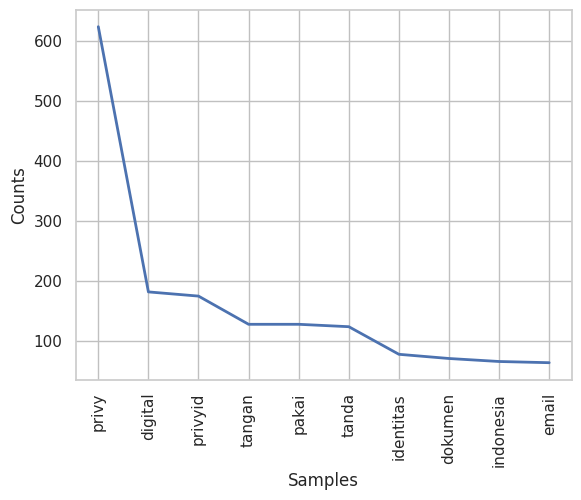

In [ ]:
import matplotlib.pyplot as plt

# plotting
fqdist.plot(10,cumulative=False)
plt.show()

In [ ]:
df_2 = df_clean[['tweet_fix']]
df_2.head()

,tweet_fix
0,startup tanda tangan digital privy dana rp mil...
1,startup sedia layan tanda tangan digital ident...
2,startup identitas digital privy raih dana rp m...
3,privy kantong dana seri miliar rupiah pimpin kkr
4,privy kantong dana seri miliar rupiah pimpin kkr


In [ ]:
from wordcloud import WordCloud

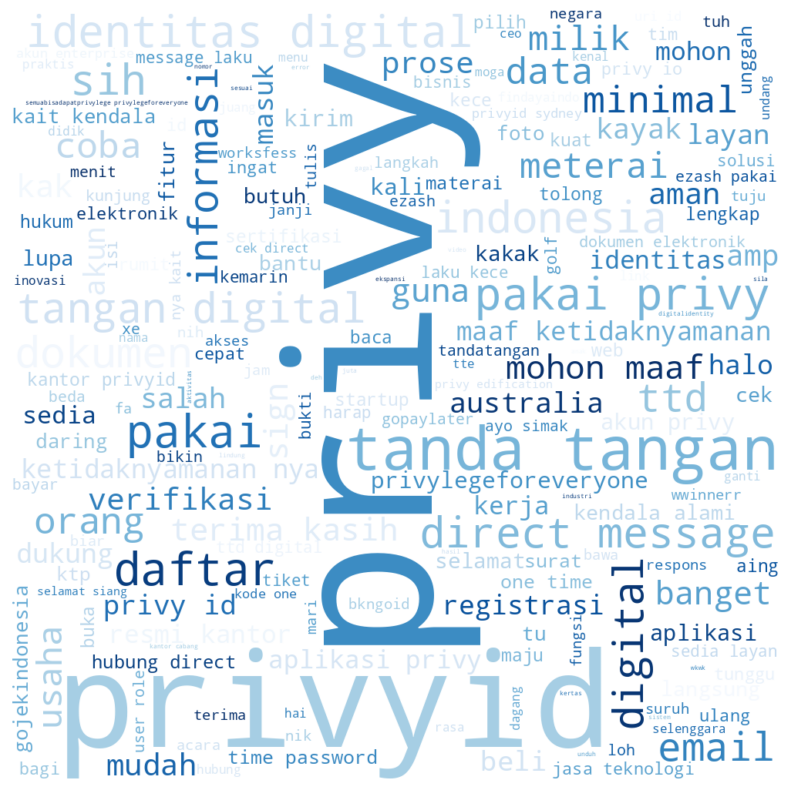

In [ ]:
all_text_s0 = ' '.join(word for word in df_2["tweet_fix"])
wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_s0)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

## sentimen

In [ ]:
!gdown --id 1hOYYAYMGSd0JoqDcBxjhtVm6koOnk-KQ

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1hOYYAYMGSd0JoqDcBxjhtVm6koOnk-KQ
To: /content/lexicon_positive_ver1.csv
100% 41.4k/41.4k [00:00<00:00, 63.8MB/s]


In [ ]:
!gdown --id 1HVydsM-fsSdIugnuSF6L9-Ai4UnRB_ju

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1HVydsM-fsSdIugnuSF6L9-Ai4UnRB_ju
To: /content/lexicon_negative_ver1.csv
100% 82.8k/82.8k [00:00<00:00, 68.8MB/s]


In [ ]:
lexicon_positive = dict()
import csv
with open('lexicon_positive_ver1.csv', 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  for row in reader:
    lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
import csv
with open('lexicon_negative_ver1.csv', 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  for row in reader:
    lexicon_negative[row[0]] = int(row[1])

In [ ]:
def sentiment_analysis_lexicon_indonesia(text):
  score = 0
  for word_pos in text:
    if (word_pos in lexicon_positive):
      score = score + lexicon_positive[word_pos]
  for word_neg in text:
    if (word_neg in lexicon_negative):
      score = score + lexicon_negative[word_neg]
  polarity=''
  if (score >= -1):
    polarity = 'positif'
  elif (score < 0):
    polarity = 'negatif'

  return score, polarity

In [ ]:
df_clean['prepos_tweet'] = df_clean.tweet_fix.str.split()

In [ ]:
results = df_clean['prepos_tweet'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
# df_clean['polarity_score'] = results[0]
df_clean['polarity'] = results[1]
print(df_clean['polarity'].value_counts())

positif    526
negatif    338
Name: polarity, dtype: int64


In [ ]:
df['prepos_tweet'] = df_clean.tweet_fix.str.split()

In [ ]:
results = df['prepos_tweet'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df['polarity_score'] = results[0]
df['polarity'] = results[1]
print(df['polarity'].value_counts())

positif    526
negatif    338
Name: polarity, dtype: int64


In [ ]:
df.head()

,day_name,tanggal,Month,Year,Date,Time,full_text,quote_count,reply_count,retweet_count,...,lang,user_id_str,conversation_id_str,username,tweet_url,processedtext,normalization,prepos_tweet,polarity_score,polarity
0,Mon,14,Nov,2022,2022-11-14,07:25:47,"Startup tanda tangan digital, Privy, mendapatk...",0,0,0,...,in,135795460,1592056183245766912,detikfinance,https://twitter.com/detikfinance/status/159205...,startup tanda tangan digital privy pendanaan r...,startup tanda tangan digital privy pendanaan r...,"[startup, tanda, tangan, digital, privy, dana,...",7,positif
1,Mon,14,Nov,2022,2022-11-14,13:03:02,Startup penyedia layanan tanda tangan digital ...,0,0,0,...,in,23046757,1592141054169711104,dailysocial,https://twitter.com/dailysocial/status/1592141...,startup penyedia layanan tanda tangan digital ...,startup penyedia layanan tanda tangan digital ...,"[startup, sedia, layan, tanda, tangan, digital...",14,positif
2,Mon,14,Nov,2022,2022-11-14,09:40:05,Startup Identitas Digital Privy Raih Pendanaan...,0,0,0,...,in,118646322,1592089978762592000,Bisniscom,https://twitter.com/Bisniscom/status/159208997...,startup identitas digital privy raih pendanaan...,startup identitas digital privy raih pendanaan...,"[startup, identitas, digital, privy, raih, dan...",9,positif
3,Mon,14,Nov,2022,2022-11-14,06:50:26,Privy Kantongi Pendanaan Seri C Sebesar 744 Mi...,0,0,0,...,in,23046757,1592047286023962880,dailysocial,https://twitter.com/dailysocial/status/1592047...,privy kantongi pendanaan seri 744 miliar rupia...,privy kantongi pendanaan seri miliar rupiah di...,"[privy, kantong, dana, seri, miliar, rupiah, p...",5,positif
4,Mon,14,Nov,2022,2022-11-14,07:05:37,Privy Kantongi Pendanaan Seri C Sebesar 744 Mi...,0,0,0,...,in,92270363,1592051107886661888,Arifai777,https://twitter.com/Arifai777/status/159205110...,privy kantongi pendanaan seri 744 miliar rupia...,privy kantongi pendanaan seri miliar rupiah di...,"[privy, kantong, dana, seri, miliar, rupiah, p...",5,positif


In [ ]:
df.to_excel('result_sentiment.xlsx',index=False)

In [ ]:
df_clean[(df_clean['polarity']=='positif')]

,tweet_clean,tweet_steamed,tweet_fix,prepos_tweet,polarity
0,"[startup, tanda, tangan, digital, privy, penda...","[startup, tanda, tangan, digital, privy, dana,...",startup tanda tangan digital privy dana rp mil...,"[startup, tanda, tangan, digital, privy, dana,...",positif
1,"[startup, penyedia, layanan, tanda, tangan, di...","[startup, sedia, layan, tanda, tangan, digital...",startup sedia layan tanda tangan digital ident...,"[startup, sedia, layan, tanda, tangan, digital...",positif
2,"[startup, identitas, digital, privy, raih, pen...","[startup, identitas, digital, privy, raih, dan...",startup identitas digital privy raih dana rp m...,"[startup, identitas, digital, privy, raih, dan...",positif
3,"[privy, kantongi, pendanaan, seri, miliar, rup...","[privy, kantong, dana, seri, miliar, rupiah, p...",privy kantong dana seri miliar rupiah pimpin kkr,"[privy, kantong, dana, seri, miliar, rupiah, p...",positif
4,"[privy, kantongi, pendanaan, seri, miliar, rup...","[privy, kantong, dana, seri, miliar, rupiah, p...",privy kantong dana seri miliar rupiah pimpin kkr,"[privy, kantong, dana, seri, miliar, rupiah, p...",positif
...,...,...,...,...,...
857,"[worksfess, privy, ttd, digital, mending, dipr...","[worksfess, privy, ttd, digital, mending, dipr...",worksfess privy ttd digital mending diprint di...,"[worksfess, privy, ttd, digital, mending, dipr...",positif
858,"[aewin, tte, berkas, om, user, password, privy...","[aewin, tte, berkas, om, user, password, privy...",aewin tte berkas om user password privy qr cod...,"[aewin, tte, berkas, om, user, password, privy...",positif
859,"[sih, meterai]","[sih, meterai]",sih meterai,"[sih, meterai]",positif
861,"[meterai, gampang, didapetinnya, dibeli, darin...","[meterai, gampang, didapetinnya, beli, daring,...",meterai gampang didapetinnya beli daring beli ...,"[meterai, gampang, didapetinnya, beli, daring,...",positif


In [ ]:
df_clean[(df_clean['polarity']=='negatif')]

,tweet_clean,tweet_steamed,tweet_fix,prepos_tweet,polarity
5,"[kkr, tanam, investasi, seri, perusahaan, digi...","[kkr, tanam, investasi, seri, usaha, digital, ...",kkr tanam investasi seri usaha digital privy,"[kkr, tanam, investasi, seri, usaha, digital, ...",negatif
9,"[privy, memperoleh, pendanaan, anak, usaha, te...","[privy, oleh, dana, anak, usaha, telkom, inves...",privy oleh dana anak usaha telkom investor ame...,"[privy, oleh, dana, anak, usaha, telkom, inves...",negatif
13,"[primasti, privy, kon, pindah, kantor, sek, wkwk]","[primasti, privy, kon, pindah, kantor, sek, wkwk]",primasti privy kon pindah kantor sek wkwk,"[primasti, privy, kon, pindah, kantor, sek, wkwk]",negatif
16,"[cek, berlaku, sertifikat, elektronik, fitur, ...","[cek, laku, sertifikat, elektronik, fitur, new...",cek laku sertifikat elektronik fitur new flow ...,"[cek, laku, sertifikat, elektronik, fitur, new...",negatif
17,"[penggunaan, layanan, tanda, tangan, elektroni...","[guna, layan, tanda, tangan, elektronik, serti...",guna layan tanda tangan elektronik sertifikasi...,"[guna, layan, tanda, tangan, elektronik, serti...",negatif
...,...,...,...,...,...
852,"[privyid, percobaan, kali, ganti, lokasi, penc...","[privyid, coba, kali, ganti, lokasi, cahaya, c...",privyid coba kali ganti lokasi cahaya cahaya i...,"[privyid, coba, kali, ganti, lokasi, cahaya, c...",negatif
853,"[privyid, cek, direct, message, admin]","[privyid, cek, direct, message, admin]",privyid cek direct message admin,"[privyid, cek, direct, message, admin]",negatif
855,"[privy, io, halo, privy, butuh, informasi, pro...","[privy, io, halo, privy, butuh, informasi, pro...",privy io halo privy butuh informasi produk esi...,"[privy, io, halo, privy, butuh, informasi, pro...",negatif
860,"[salah, memiliki, fungsi, ciri, ciri, meterai,...","[salah, milik, fungsi, ciri, ciri, meterai, fi...",salah milik fungsi ciri ciri meterai fisik bed...,"[salah, milik, fungsi, ciri, ciri, meterai, fi...",negatif


## SNA

In [ ]:
import pandas as pd
import spacy
import networkx as nx                        # a really useful network analysis library
import matplotlib.pyplot as plt
# from networkx.algorithms import community   # not used, yet...
import datetime                              # access to %%time, for timing individual notebook cells
import os

In [ ]:
!python -m spacy download en_core_web_lg
!python -m spacy download en_core_web_sm

2023-11-23 05:07:28.763744: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-23 05:07:28.763827: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-23 05:07:28.763898: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-23 05:07:31.329228: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
2023-11-23 05:08:24.461226: E tensorflow/compiler/xla/s

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864 entries, 0 to 863
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet_clean    864 non-null    object
 1   tweet_steamed  864 non-null    object
 2   tweet_fix      864 non-null    object
 3   prepos_tweet   864 non-null    object
 4   polarity       864 non-null    object
dtypes: object(5)
memory usage: 33.9+ KB


In [ ]:
nlp = spacy.load('en_core_web_lg')           # A more detailed model (with higher-dimension word vectors) - 13s to load, normally
#nlp = spacy.load('en_core_web_md')           # a smaller model, e.g. for testing

In [ ]:
df['tweet'] = df_clean['tweet_fix'].apply(nlp)

In [ ]:
print(df['tweet'][0].similarity(df['tweet'][1]))
print(df['tweet'][0].similarity(df['tweet'][10]))
print(df['tweet'][1].similarity(df['tweet'][10]))

0.8989408856484971
0.41868793533042675
0.33826798470753117


In [ ]:
# takes 1s for 500 nodes - but of course this won't scale linearly!
raw_G = nx.Graph() # undirected
n = 0


for i in df['tweet']:        # sure, it's inefficient, but it will do
    for j in df['tweet']:
        if i != j:
            if not (raw_G.has_edge(j, i)):
                sim = i.similarity(j)
                raw_G.add_edge(i, j, weight = sim)
                n = n + 1

print(raw_G.number_of_nodes(), "nodes, and", raw_G.number_of_edges(), "edges created.")

<ipython-input-78-fdb53a73149e>:10: UserWarning:

[W008] Evaluating Doc.similarity based on empty vectors.



864 nodes, and 372816 edges created.


In [ ]:
edges_to_kill = []
min_wt = 0.94      # this is our cutoff value for a minimum edge-weight

for n, nbrs in raw_G.adj.items():
    #print("\nProcessing origin-node:", n, "... ")
    for nbr, eattr in nbrs.items():
        # remove edges below a certain weight
        data = eattr['weight']
        if data < min_wt:
            # print('(%.3f)' % (data))
            # print('(%d, %d, %.3f)' % (n, nbr, data))
            #print("\nNode: ", n, "\n <-", data, "-> ", "\nNeighbour: ", nbr)
            edges_to_kill.append((n, nbr))

print("\n", len(edges_to_kill) / 2, "edges to kill (of", raw_G.number_of_edges(), "), before de-duplicating")

In [ ]:
for u, v in edges_to_kill:
    if raw_G.has_edge(u, v):   # catches (e.g.) those edges where we've removed them using reverse ... (v, u)
        raw_G.remove_edge(u, v)

In [ ]:
strong_G = raw_G
print(strong_G.number_of_edges())

1130


In [ ]:
nx.draw(strong_G, node_size=20, edge_color='gray')

In [ ]:
strong_G.remove_nodes_from(list(nx.isolates(strong_G)))

In [ ]:
from math import sqrt
count = strong_G.number_of_nodes()
equilibrium = 5 / sqrt(count)    # default for this is 1/sqrt(n), but this will 'blow out' the layout for better visibility
pos = nx.fruchterman_reingold_layout(strong_G, k=equilibrium, iterations=300)
nx.draw(strong_G, pos=pos, node_size=10, edge_color='gray')

In [ ]:
plt.rcParams['figure.figsize'] = [18, 9]  # a better aspect ratio for labelled nodes

nx.draw(strong_G, pos, font_size=3, node_size=50, edge_color='gray', with_labels=False)
for p in pos:  # raise positions of the labels, relative to the nodes
    pos[p][1] -= 0.03
nx.draw_networkx_labels(strong_G, pos, font_size=5, font_color='k')

plt.show()

In [ ]:
# if n_words=1 -> unigrams, if n_words=2 -> bigrams..
def get_top_Nwords(corpus, n=None, remove_stop_words=False, n_words=1):
    if remove_stop_words:
        vec = CountVectorizer(stop_words='english', ngram_range=(n_words, n_words)).fit(corpus)
    else:
        vec = CountVectorizer(ngram_range=(n_words, n_words)).fit(corpus)

    bag_ofWords =vec.transform(corpus)
    sum_words = bag_ofWords.sum(axis=0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
common_words = get_top_Nwords(df_clean['tweet_fix'].drop_duplicates(), 50, remove_stop_words=True, n_words=2)
for word, freq in common_words:
    print(word, freq)

## Bigram

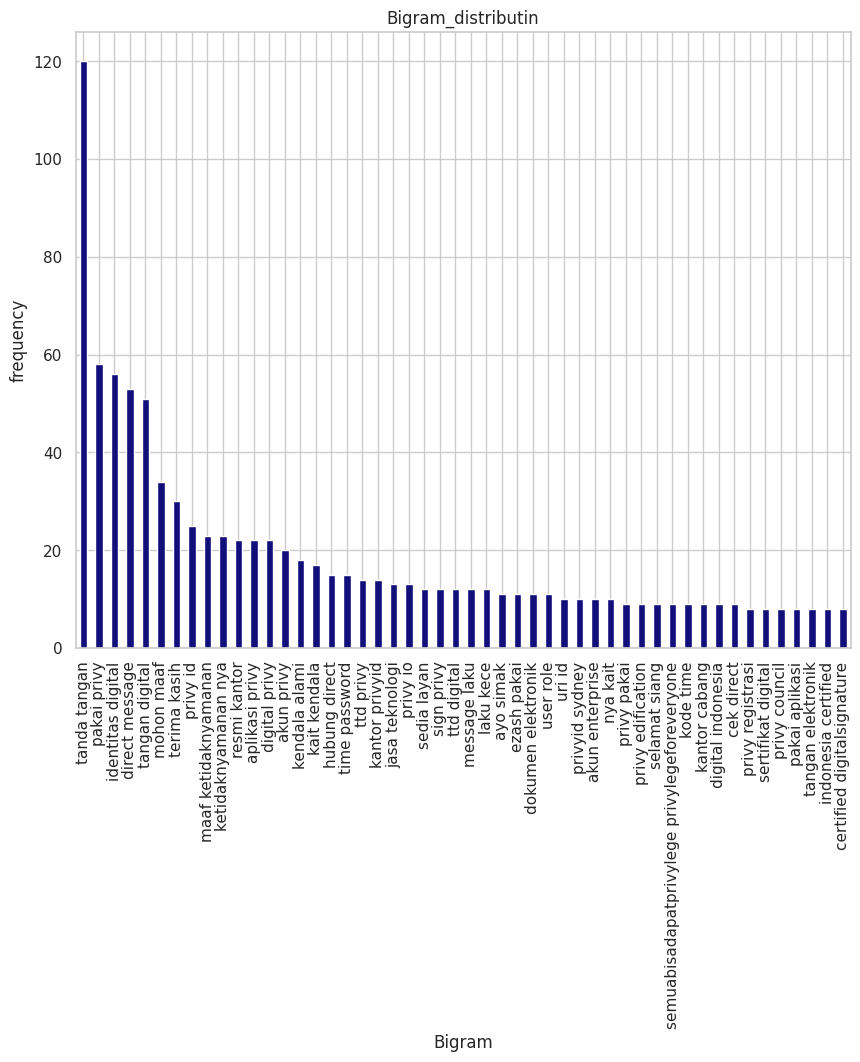

In [ ]:
train_temp =pd.DataFrame(common_words, columns=['text', 'count'])
fig = plt.figure(figsize=(10,8))
ax1 = train_temp.groupby('text').sum()['count'].sort_values(ascending=False).plot(kind='bar',
                                                                            color='#120f7b')
ax1.set_title("Bigram_distributin")
ax1.set_xlabel('Bigram')
ax1.set_ylabel("frequency")
plt.show()

In [ ]:
common_words = get_top_Nwords(df_clean['tweet_fix'].drop_duplicates(), 50, remove_stop_words=True, n_words=3)
for word, freq in common_words:
    print(word, freq)

## Tigram

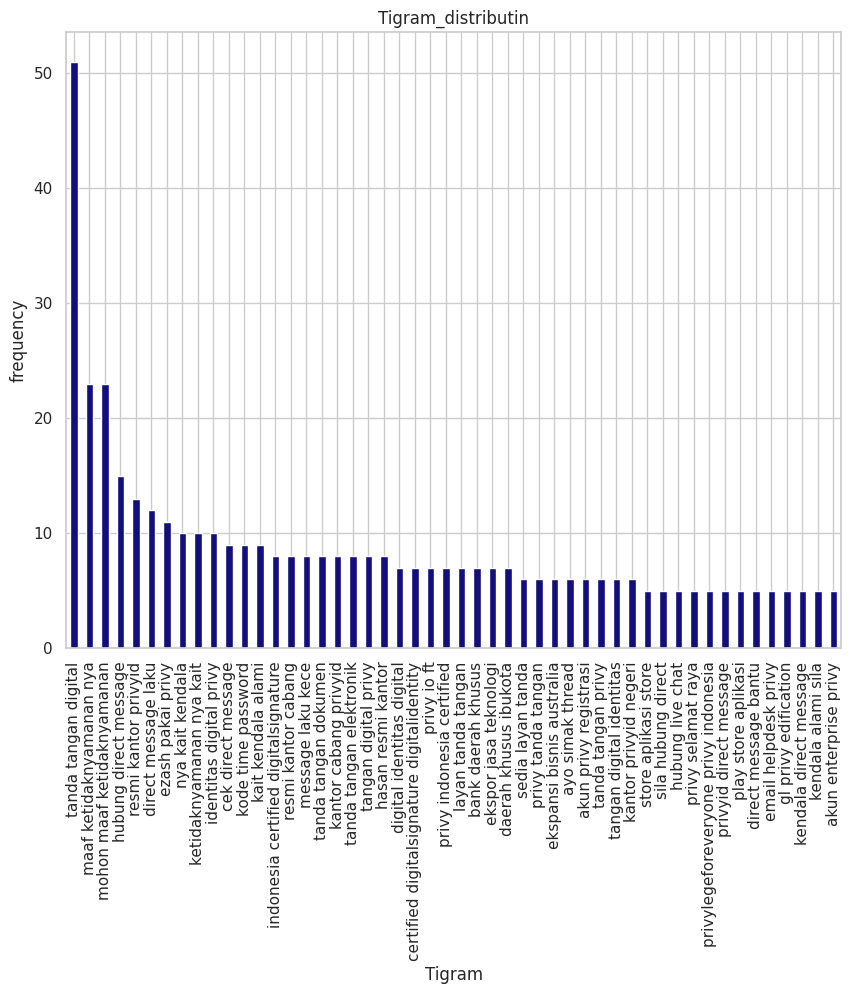

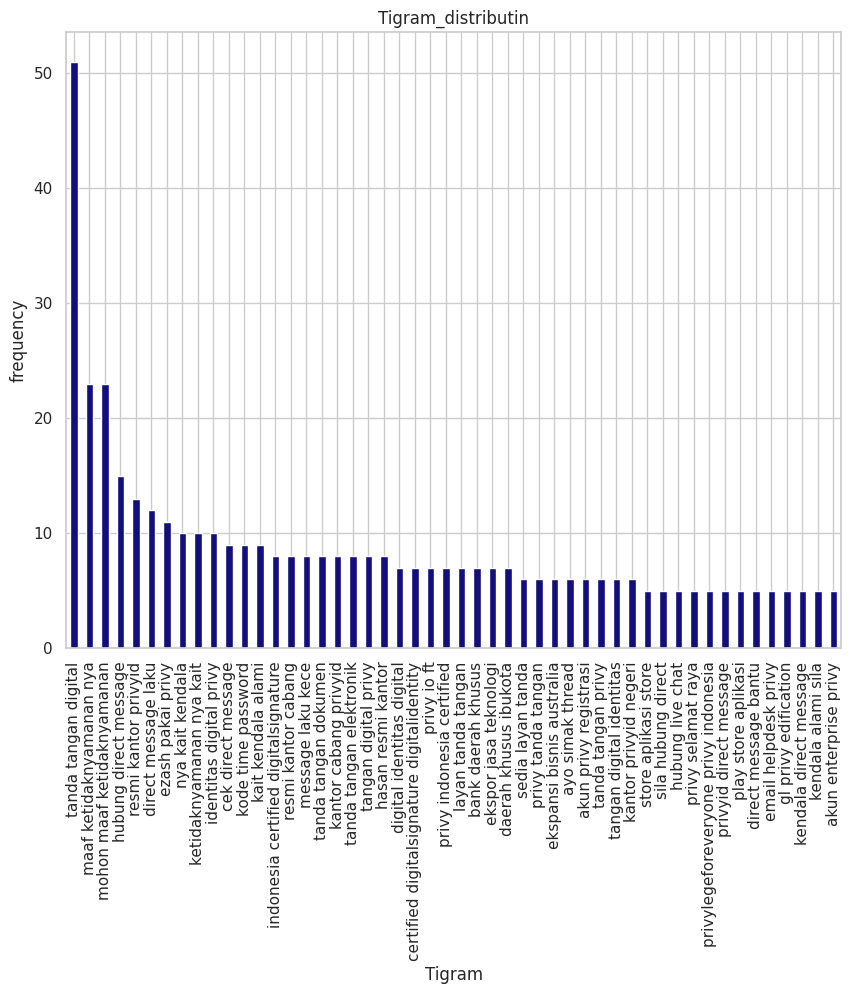

In [ ]:
train_temp =pd.DataFrame(common_words, columns=['text', 'count'])
fig = plt.figure(figsize=(10,8))
ax1 = train_temp.groupby('text').sum()['count'].sort_values(ascending=False).plot(kind='bar',
                                                                            color='#120f7b')
ax1.set_title("Tigram_distributin")
ax1.set_xlabel('Tigram')
ax1.set_ylabel("frequency")
plt.show()

In [ ]:
bigram = get_top_Nwords(df_clean['tweet_fix'].drop_duplicates(), remove_stop_words=True, n_words=2)

In [ ]:
bigram_df = pd.DataFrame(bigram, columns=['bigram','total'])

In [ ]:
bigram_df.to_csv('bigram.csv',index=False)

export

In [ ]:
tigram = get_top_Nwords(df_clean['tweet_fix'].drop_duplicates(), remove_stop_words=True, n_words=3)

In [ ]:
tigram_df = pd.DataFrame(tigram, columns=['tigram','total'])

In [ ]:
tigram_df.to_csv('tigram.csv',index=False)